# Backtest

In [2]:
import pandas as pd

df_predictions = pd.read_csv('../reports/hist_data.csv')
# I'am adding 1 day to the date because the values are the predictions for the next day.
# Therefore the prediction was run the first day of the month but the prediction is for the next day.
df_predictions['date'] = pd.to_datetime(df_predictions['Date'], format='%d.%m.%Y', dayfirst=True) + pd.Timedelta('1 day')
df_predictions = df_predictions.rename(columns={'Date': 'date_predictions'})
df_predictions.tail()

,date_predictions,news,finance,tech,head,date
78,25.03.2025,6,8.0,6.5,6.0,2025-03-26
79,26.03.2025,7,7.0,8.0,7.0,2025-03-27
80,27.03.2025,7,7.0,8.0,7.0,2025-03-28
81,28.03.2025,5,6.0,4.0,5.0,2025-03-29
82,29.03.2025,5,3.0,6.0,5.0,2025-03-30


In [3]:
from datetime import datetime, timedelta
import yfinance as yf

def download_yfinance_data(ticker_symbol: str,
                           start_date: datetime,
                           asset: str,
                           end_date: datetime) -> pd.DataFrame:

    # Download the data
    yfinance_data = yf.download(ticker_symbol, start=start_date, end=end_date, interval='1d')
    yfinance_data.columns = yfinance_data.columns.droplevel(1)  # Drops the second level ('BTC-USD')
    yfinance_data.reset_index(inplace=True) # Reset the index to have the 'Date' as a column

    # Modify the DataFrame to include the ticker symbol and asset type
    yfinance_data['ticker'] = ticker_symbol
    yfinance_data['asset'] = asset
    yfinance_data['Date'] = pd.to_datetime(yfinance_data['Date'], format='%d.%m.%Y', dayfirst=True)


    yfinance_data = yfinance_data.rename(
        columns={'Price': 'price',
                 'Adj Close': 'adj_close',
                 'Close': 'close',
                 'High': 'high',
                 'Low': 'low',
                 'Open': 'open',
                 'Volume': 'volume',
                 'Date': 'date'})

    yfinance_data['pct_change'] = yfinance_data['close'].pct_change() * 100

    return yfinance_data


df_yfinance = download_yfinance_data(
    ticker_symbol='BTC-USD',
    start_date=datetime.now() - timedelta(days=150),
    asset='bitcoin',
    end_date=datetime.now()
    )

df_yfinance.tail()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,date,close,high,low,open,volume,ticker,asset,pct_change
146,2025-03-25,87471.703125,88542.398438,86346.078125,87512.820312,30005840049,BTC-USD,bitcoin,-0.031099
147,2025-03-26,86900.882812,88292.156250,85861.453125,87460.234375,26704046038,BTC-USD,bitcoin,-0.652577
148,2025-03-27,87177.101562,87786.726562,85837.937500,86896.257812,24413471941,BTC-USD,bitcoin,0.317855
149,2025-03-28,84353.148438,87489.859375,83557.640625,87185.234375,34198619509,BTC-USD,bitcoin,-3.239329
150,2025-03-29,83855.953125,84543.101562,83658.312500,84370.781250,27546265600,BTC-USD,bitcoin,-0.589421


In [4]:
# Merge the DataFrames on 'Pricedate'
merged_df = pd.merge(df_yfinance, df_predictions, on='date', how='left') # left keeps all rows from df1
merged_df.tail()

,date,close,high,low,open,volume,ticker,asset,pct_change,date_predictions,news,finance,tech,head
149,2025-03-25,87471.703125,88542.398438,86346.078125,87512.820312,30005840049,BTC-USD,bitcoin,-0.031099,24.03.2025,7.0,6.0,8.0,7.0
150,2025-03-26,86900.882812,88292.156250,85861.453125,87460.234375,26704046038,BTC-USD,bitcoin,-0.652577,25.03.2025,6.0,8.0,6.5,6.0
151,2025-03-27,87177.101562,87786.726562,85837.937500,86896.257812,24413471941,BTC-USD,bitcoin,0.317855,26.03.2025,7.0,7.0,8.0,7.0
152,2025-03-28,84353.148438,87489.859375,83557.640625,87185.234375,34198619509,BTC-USD,bitcoin,-3.239329,27.03.2025,7.0,7.0,8.0,7.0
153,2025-03-29,83855.953125,84543.101562,83658.312500,84370.781250,27546265600,BTC-USD,bitcoin,-0.589421,28.03.2025,5.0,6.0,4.0,5.0


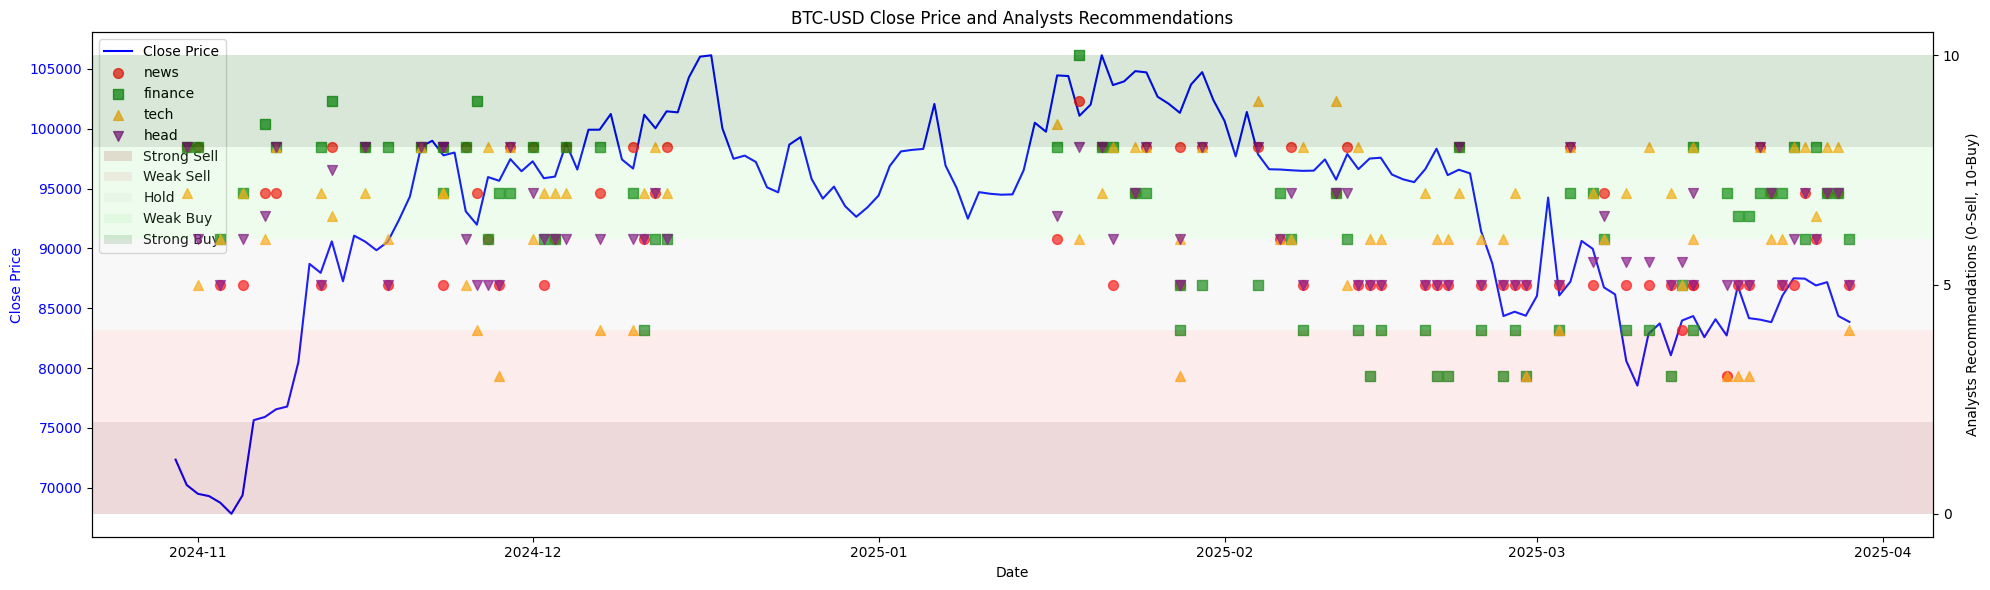

In [5]:
import matplotlib.pyplot as plt


merged_df['date'] = pd.to_datetime(merged_df['date'])

# Create the plot
fig, ax1 = plt.subplots(figsize=(20, 6))

# Plot 'close' price as a line chart
ax1.plot(merged_df['date'], merged_df['close'], color='blue', label='Close Price')
ax1.set_xlabel('Date')
ax1.set_ylabel('Close Price', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis for the analysts' recommendations
ax2 = ax1.twinx()

# Plot the analysts' recommendations as scatter plots with vertical lines
analysts = ['news', 'finance', 'tech', 'head']
colors = ['red', 'green', 'orange', 'purple']
markers = ['o', 's', '^', 'v']  # Different markers for each analyst

for i, analyst in enumerate(analysts):
    ax2.scatter(merged_df['date'], merged_df[analyst], color=colors[i], marker=markers[i], label=analyst, alpha=0.7, s=50) #added alpha and s to change marker transparency and size.



ax2.set_ylabel('Analysts Recommendations (0-Sell, 10-Buy)', color='black')
ax2.tick_params(axis='y', labelcolor='black')
ax2.set_yticks([0, 5, 10])

# Add recommendation band
ax2.axhspan(0, 2, facecolor='darkred', alpha=0.15, label='Strong Sell')
ax2.axhspan(2, 4, facecolor='lightcoral', alpha=0.15, label='Weak Sell')
ax2.axhspan(4, 6, facecolor='lightgray', alpha=0.15, label='Hold')
ax2.axhspan(6, 8, facecolor='lightgreen', alpha=0.15, label='Weak Buy')
ax2.axhspan(8, 10, facecolor='darkgreen', alpha=0.15, label='Strong Buy')

# Add title and legend
plt.title('BTC-USD Close Price and Analysts Recommendations')

# Create a more informative legend
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
handles = handles1 + handles2
labels = labels1 + labels2
unique = []
for h, l in zip(handles, labels):
    if l not in [label for handle, label in unique]:
        unique.append((h, l))

ax1.legend(*zip(*unique), loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()

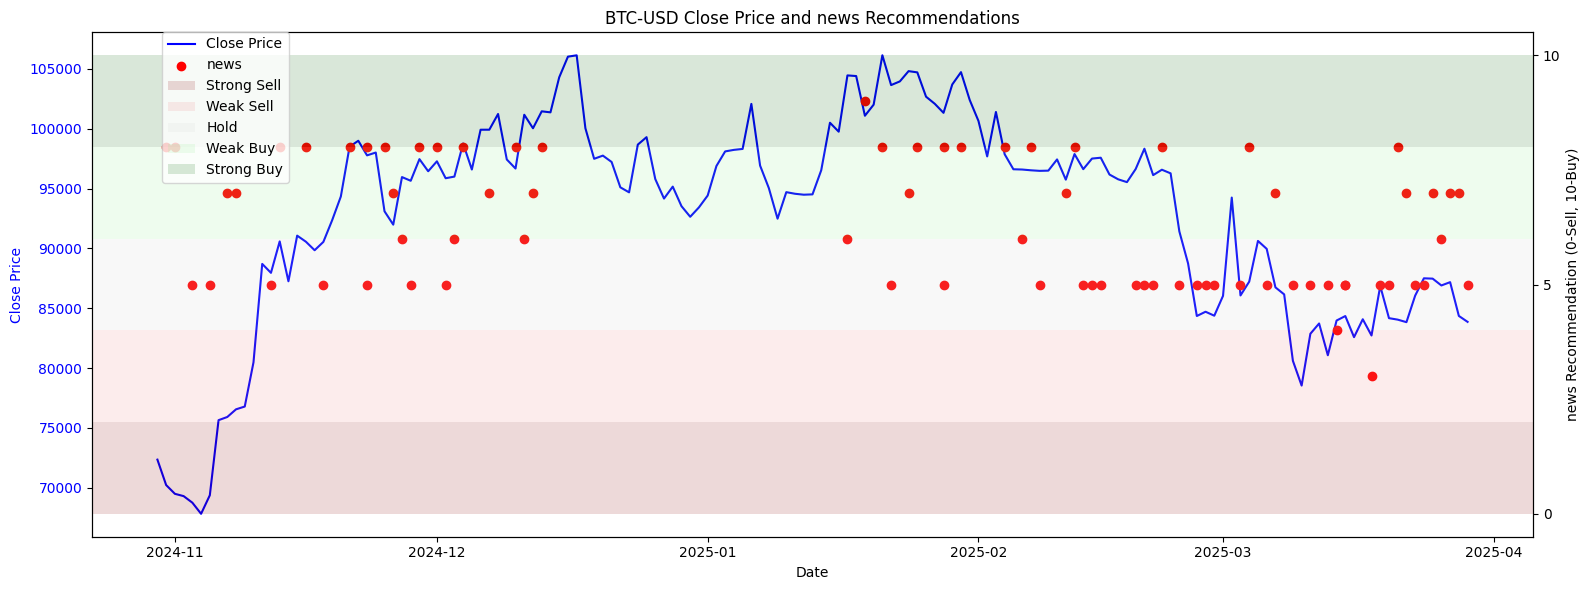

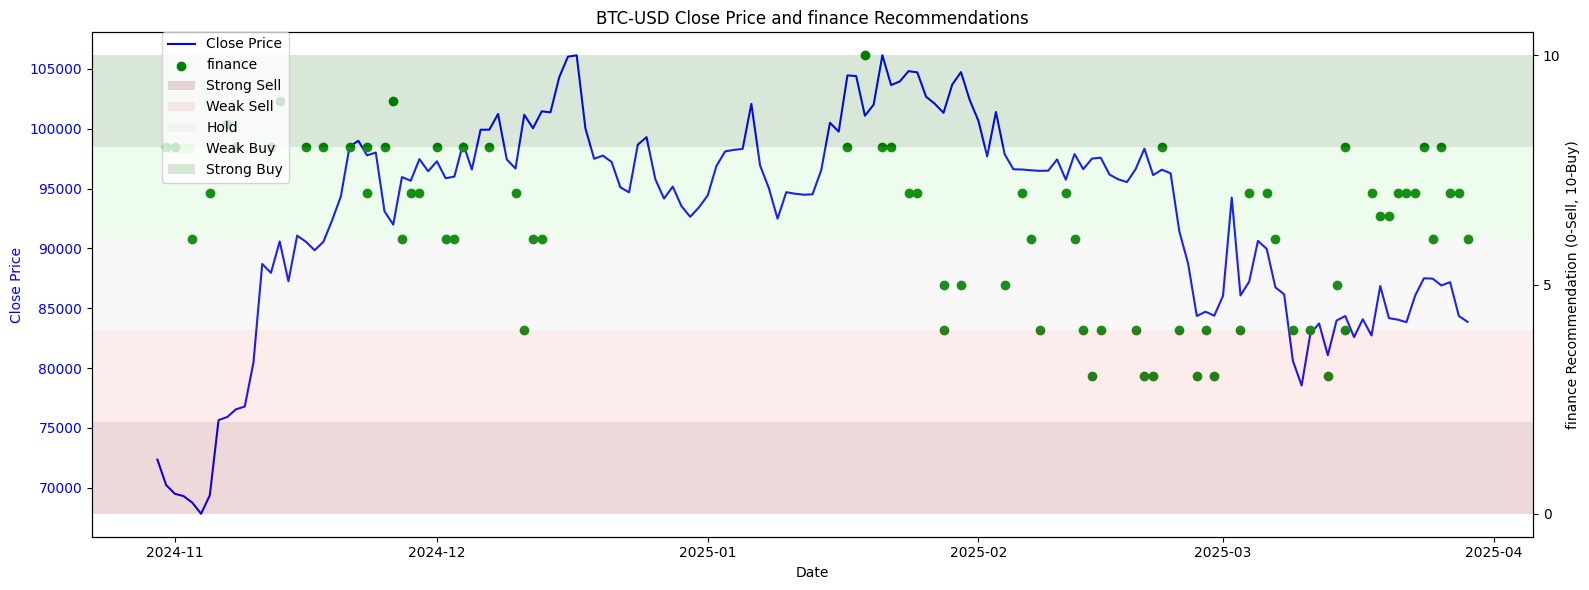

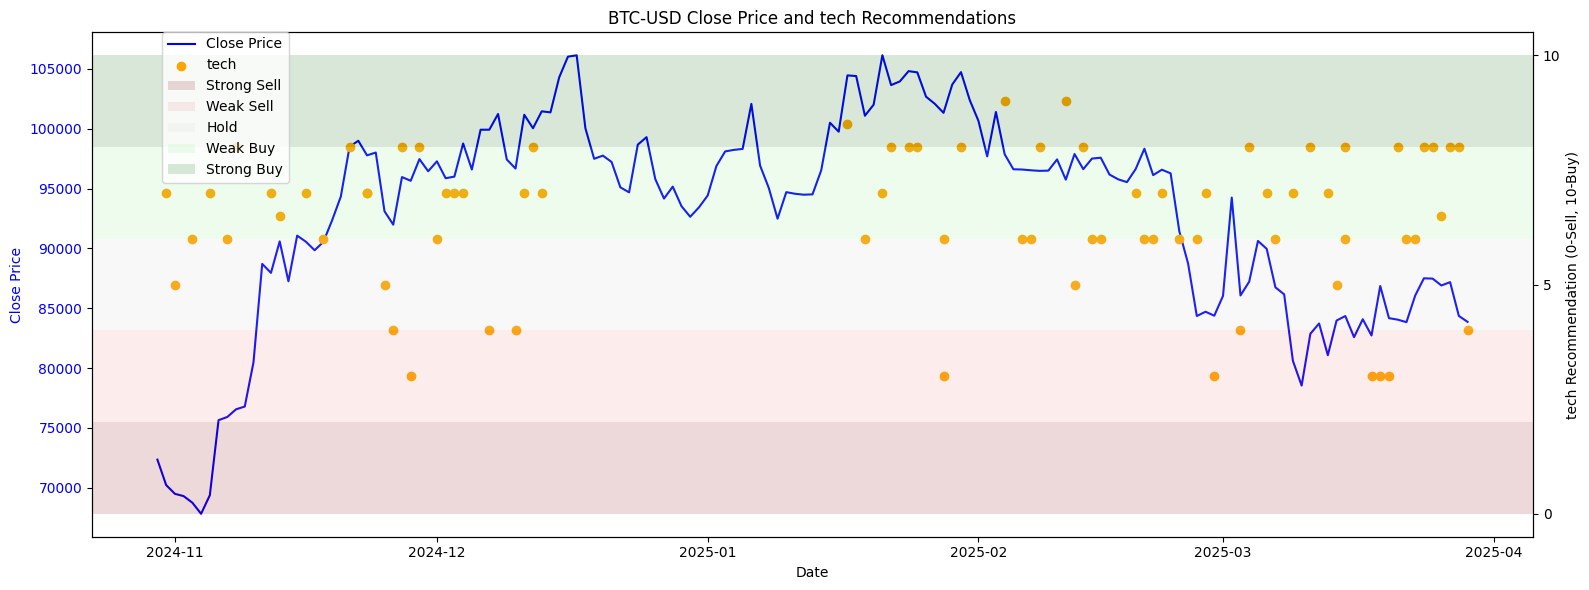

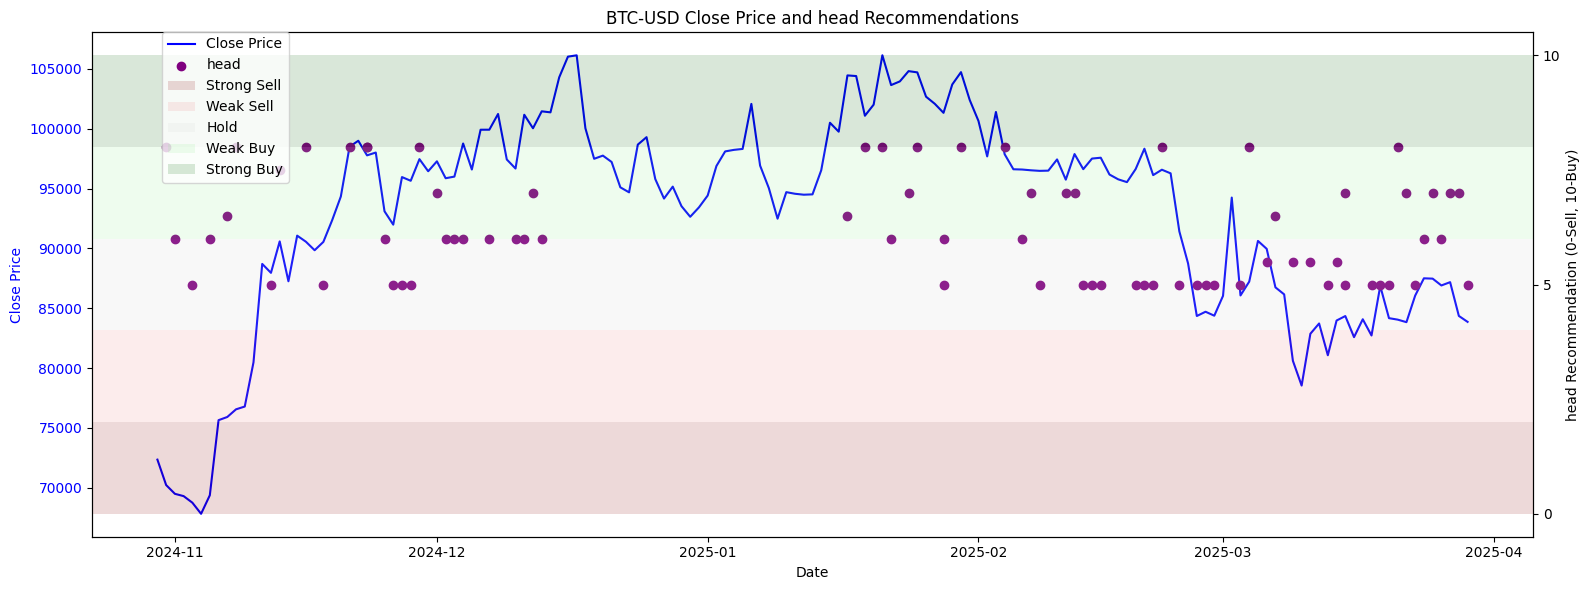

In [6]:
merged_df['date'] = pd.to_datetime(merged_df['date'])

# Analysts list
analysts = ['news', 'finance', 'tech', 'head']
colors = ['red', 'green', 'orange', 'purple']

# Create a plot for each analyst
for i, analyst in enumerate(analysts):
    fig, ax1 = plt.subplots(figsize=(16, 6))

    # Plot 'close' price as a line chart
    ax1.plot(merged_df['date'], merged_df['close'], color='blue', label='Close Price')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Close Price', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    # Create a second y-axis for the analyst's recommendations
    ax2 = ax1.twinx()

    # Plot the analyst's recommendations as scatter plots with vertical lines
    ax2.scatter(merged_df['date'], merged_df[analyst], color=colors[i], marker='o', label=analyst)

    ax2.set_ylabel(f'{analyst} Recommendation (0-Sell, 10-Buy)', color='black')
    ax2.tick_params(axis='y', labelcolor='black')
    ax2.set_yticks([0, 5, 10])

    # Add recommendation band
    ax2.axhspan(0, 2, facecolor='darkred', alpha=0.15, label='Strong Sell')
    ax2.axhspan(2, 4, facecolor='lightcoral', alpha=0.15, label='Weak Sell')
    ax2.axhspan(4, 6, facecolor='lightgray', alpha=0.15, label='Hold')
    ax2.axhspan(6, 8, facecolor='lightgreen', alpha=0.15, label='Weak Buy')
    ax2.axhspan(8, 10, facecolor='darkgreen', alpha=0.15, label='Strong Buy')

    # Add title and legend
    plt.title(f'BTC-USD Close Price and {analyst} Recommendations')
    fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.95))

    # Show the plot
    plt.tight_layout()
    plt.show()

# Numerical backtest

In [7]:
# Convert 'date' to datetime
merged_df['date'] = pd.to_datetime(merged_df['date'])

# Analysts list
analyst = ['news', 'finance', 'tech', 'head']

transactions = []
final_return = {}
initial_capital = 10000
shares = 0
capital = initial_capital
results = {}

for i in range(len(merged_df) - 1):
    recommendation = merged_df[analyst].iloc[i] # recommendation for the current day (t)
    print(recommendation)
    open_price = merged_df['open'].iloc[i + 1] # open price for the next day (t+1)
    if recommendation <= 4 and shares > 0:  # Sell signal
        capital += shares * open_price
        transactions.append({
            'date': merged_df['date'].iloc[i + 1],
            'action': 'sell',
            'price': open_price,
            'shares': shares,
            'capital': capital
        })
        print(f'{analyst}: Sold {shares} shares at ${open_price:.2f}, value sold {capital:.2f}, recommendation {recommendation}')
        shares = 0

    elif recommendation >= 6 and capital > 1000:  # Buy signal and enough capital
        print(f'buying power: {capital:.5f}')
        shares = capital / open_price
        capital -= shares * open_price
        transactions.append({
            'date': merged_df['date'].iloc[i + 1],
            'action': 'buy',
            'price': open_price,
            'shares': shares,
            'capital': capital
        })
        print(f'{analyst}: Bought {shares} shares at ${open_price:.2f} capital {capital:.2f} - value bought {shares * open_price - capital:.2f}, recommendation {recommendation}')


    if shares > 0 and merged_df['date'].iloc[i] == merged_df['date'].iloc[-2]:
        capital += shares * merged_df['close'].iloc[-1]
        transactions.append({
            'date': merged_df['date'].iloc[-1],
            'action': 'sell',
            'price': merged_df['close'].iloc[-1],
            'shares': shares,
            'capital': capital
        })
        shares = 0
        print(f'{analyst}: Closed out {shares} shares at ${merged_df["close"].iloc[-1]:.2f}')

    print(f'===Return {analyst}: {(capital / initial_capital)-1}===')

news      NaN
finance   NaN
tech      NaN
head      NaN
Name: 0, dtype: float64


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

# Create reflection dataset

In [8]:
df_head = merged_df[merged_df['head'].notna()]
df_head = df_head[abs(df_head['pct_change']) > 3]

# Bitcoin increased more than 3% and the head recommendation is less than 8 (i.e. no strong buy)
missed_strong_buy = df_head[(df_head['head'] < 8) & (df_head['pct_change'] > 3)]

# Bitcoin decreased more than 3% and the head recommendation is higher than > 3 (i.e. no strong sell)
missed_strong_sell = df_head[(df_head['head'] > 3) & (df_head['pct_change'] < -3)]

# Correct the negative first before getting into the postitive.
# Bitcoin increased more than 3% and the head recommendation was higher than 7
caught_positive = df_head[(df_head['head'] > 7) & (df_head['pct_change'] > 3)]

# Bitcoin decreased more than 3% and the head recommendation is lower than 4
caught_loss = df_head[(df_head['head'] < 4) & (df_head['pct_change'] < -3)]

In [10]:
# The report to select is one prior
missed_strong_sell

,date,close,high,low,open,volume,ticker,asset,pct_change,date_predictions,news,finance,tech,head
27,2024-11-25,93102.296875,98935.031250,92642.914062,98033.445312,80909462490,BTC-USD,bitcoin,-5.011052,24.11.2024,8.0,8.0,5.0,6.0
82,2025-01-19,101089.609375,106299.796875,99570.531250,104411.289062,76789928525,BTC-USD,bitcoin,-3.178357,18.01.2025,9.0,10.0,6.0,8.0
99,2025-02-04,97871.820312,101745.617188,96208.109375,101398.718750,73002130211,BTC-USD,bitcoin,-3.484628,03.02.2025,8.0,5.0,9.0,8.0
119,2025-02-24,91418.171875,96503.453125,91371.742188,96277.960938,44046480529,BTC-USD,bitcoin,-5.043682,23.02.2025,5.0,4.0,6.0,5.0
121,2025-02-26,84347.023438,89286.250000,82131.898438,88638.890625,64597492134,BTC-USD,bitcoin,-4.946290,25.02.2025,5.0,3.0,6.0,5.0
126,2025-03-03,86065.671875,94429.750000,85081.304688,94248.421875,70072228536,BTC-USD,bitcoin,-8.682040,02.03.2025,5.0,4.0,4.0,5.0
130,2025-03-07,86742.671875,91191.046875,84717.679688,89963.281250,65945677657,BTC-USD,bitcoin,-3.578249,06.03.2025,7.0,6.0,6.0,6.5
132,2025-03-09,80601.039062,86471.132812,80052.484375,86154.304688,30899345977,BTC-USD,bitcoin,-6.446034,08.03.2025,5.0,4.0,7.0,5.5
136,2025-03-13,81066.703125,84301.695312,79931.851562,83724.921875,31412940153,BTC-USD,bitcoin,-3.171980,12.03.2025,5.0,3.0,7.0,5.0
144,2025-03-20,84167.195312,87443.265625,83647.195312,86872.953125,29028988961,BTC-USD,bitcoin,-3.093725,19.03.2025,5.0,6.5,3.0,5.0


In [11]:
# The report to select is one prior
missed_strong_buy

,date,close,high,low,open,volume,ticker,asset,pct_change,date_predictions,news,finance,tech,head
29,2024-11-27,95962.531250,97361.179688,91778.664062,91978.140625,71133452438,BTC-USD,bitcoin,4.323745,26.11.2024,6.0,6.0,8.0,5.0
43,2024-12-11,101173.031250,101913.359375,95747.226562,96656.062500,85391409936,BTC-USD,bitcoin,4.652270,10.12.2024,6.0,4.0,7.0,6.0
80,2025-01-17,104462.039062,105884.226562,99948.906250,100025.765625,71888972663,BTC-USD,bitcoin,4.716599,16.01.2025,6.0,8.0,8.5,6.5
134,2025-03-11,82862.210938,83577.757812,76624.250000,78523.875000,54702837196,BTC-USD,bitcoin,5.513945,10.03.2025,5.0,4.0,8.0,5.5
137,2025-03-14,83969.101562,85263.289062,80797.562500,81066.992188,29588112414,BTC-USD,bitcoin,3.580260,13.03.2025,4.0,5.0,5.0,5.5
143,2025-03-19,86854.226562,87021.187500,82569.726562,82718.804688,34931960257,BTC-USD,bitcoin,4.999760,18.03.2025,5.0,6.5,3.0,5.0


In [14]:
pos_rec_neg_delta = df_head[(df_head['head'] >= 5) & (df_head['pct_change'] < 0)]
pos_rec_neg_delta

,date,close,high,low,open,volume,ticker,asset,pct_change,date_predictions,news,finance,tech,head
27,2024-11-25,93102.296875,98935.031250,92642.914062,98033.445312,80909462490,BTC-USD,bitcoin,-5.011052,24.11.2024,8.0,8.0,5.0,6.0
82,2025-01-19,101089.609375,106299.796875,99570.531250,104411.289062,76789928525,BTC-USD,bitcoin,-3.178357,18.01.2025,9.0,10.0,6.0,8.0
99,2025-02-04,97871.820312,101745.617188,96208.109375,101398.718750,73002130211,BTC-USD,bitcoin,-3.484628,03.02.2025,8.0,5.0,9.0,8.0
119,2025-02-24,91418.171875,96503.453125,91371.742188,96277.960938,44046480529,BTC-USD,bitcoin,-5.043682,23.02.2025,5.0,4.0,6.0,5.0
121,2025-02-26,84347.023438,89286.250000,82131.898438,88638.890625,64597492134,BTC-USD,bitcoin,-4.946290,25.02.2025,5.0,3.0,6.0,5.0
126,2025-03-03,86065.671875,94429.750000,85081.304688,94248.421875,70072228536,BTC-USD,bitcoin,-8.682040,02.03.2025,5.0,4.0,4.0,5.0
130,2025-03-07,86742.671875,91191.046875,84717.679688,89963.281250,65945677657,BTC-USD,bitcoin,-3.578249,06.03.2025,7.0,6.0,6.0,6.5
132,2025-03-09,80601.039062,86471.132812,80052.484375,86154.304688,30899345977,BTC-USD,bitcoin,-6.446034,08.03.2025,5.0,4.0,7.0,5.5
136,2025-03-13,81066.703125,84301.695312,79931.851562,83724.921875,31412940153,BTC-USD,bitcoin,-3.171980,12.03.2025,5.0,3.0,7.0,5.0
144,2025-03-20,84167.195312,87443.265625,83647.195312,86872.953125,29028988961,BTC-USD,bitcoin,-3.093725,19.03.2025,5.0,6.5,3.0,5.0
